In [1]:
#Installing the imbalanced learn module for access to a variety of over-sampling methods

#!pip install imbalanced-learn
#!pip install numpy==1.21
#!pip install lxml

In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [21]:
df = pd.read_csv('Data/clean_gss.csv')
df.head()

,Unnamed: 0,LONELY2,SATJOB,MOREDAYS,WRKHOME,HLTHPHYS,HLTHMNTL,CONWKDAY,PARTLSC,AGE,MARITAL,EDUC,is_si,marital_cat,MOREWEEKS,Age Group
0,3,2.0,1.0,2.0,1.0,1.0,1.0,4.0,3.0,63.0,1.0,4,0,1,1,4
1,6,3.0,1.0,1.0,1.0,3.0,2.0,3.0,2.0,59.0,3.0,3,1,0,1,3
2,7,1.0,1.0,24.0,1.0,2.0,3.0,4.0,5.0,43.0,5.0,2,0,0,4,2
3,9,3.0,2.0,3.0,1.0,2.0,3.0,4.0,1.0,55.0,1.0,2,1,1,1,3
4,11,3.0,2.0,6.0,1.0,3.0,3.0,2.0,1.0,34.0,4.0,3,1,0,1,2


In [22]:
# Getting rid of redundant columns from initial dataframe

gss= df[['SATJOB','WRKHOME', 'HLTHPHYS', 'HLTHMNTL', 'CONWKDAY', 'PARTLSC','marital_cat', 'EDUC', 'is_si', 'MOREWEEKS', 'Age Group']]
gss.head()

,SATJOB,WRKHOME,HLTHPHYS,HLTHMNTL,CONWKDAY,PARTLSC,marital_cat,EDUC,is_si,MOREWEEKS,Age Group
0,1.0,1.0,1.0,1.0,4.0,3.0,1,4,0,1,4
1,1.0,1.0,3.0,2.0,3.0,2.0,0,3,1,1,3
2,1.0,1.0,2.0,3.0,4.0,5.0,0,2,0,4,2
3,2.0,1.0,2.0,3.0,4.0,1.0,1,2,1,1,3
4,2.0,1.0,3.0,3.0,2.0,1.0,0,3,1,1,2


<AxesSubplot:>

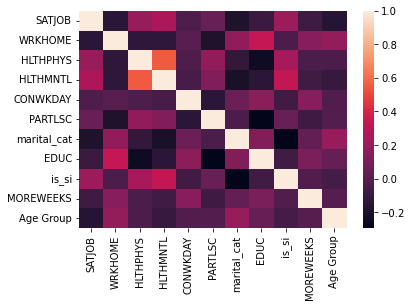

In [23]:
# Checking for multicollinearity- looks good

corr = gss.corr()
sns.heatmap(corr)

In [24]:
# Marital status is the only nominal categorical variable in this dataframe. Using get_dummies to one-hot encode and
# dropping first level of marital status: a zero for marital_2, marital_3, marital_4, and marital_5 implies row belongs
# to marital_1. The rest of the variables are ordinal and attempting to run logit with variables as-is.

gss= pd.get_dummies(gss, columns= ['marital_cat'], prefix= 'Marital', drop_first= True)
gss.head()

,SATJOB,WRKHOME,HLTHPHYS,HLTHMNTL,CONWKDAY,PARTLSC,EDUC,is_si,MOREWEEKS,Age Group,Marital_1
0,1.0,1.0,1.0,1.0,4.0,3.0,4,0,1,4,1
1,1.0,1.0,3.0,2.0,3.0,2.0,3,1,1,3,0
2,1.0,1.0,2.0,3.0,4.0,5.0,2,0,4,2,0
3,2.0,1.0,2.0,3.0,4.0,1.0,2,1,1,3,1
4,2.0,1.0,3.0,3.0,2.0,1.0,3,1,1,2,0


In [25]:
# Starting to split data to prepare for modeling

X= gss[['SATJOB','WRKHOME', 'HLTHPHYS', 'HLTHMNTL', 'CONWKDAY', 'PARTLSC','EDUC', 'MOREWEEKS', 'Age Group', 'Marital_1' ]]
y= gss['is_si']

In [26]:
from imblearn.over_sampling import SMOTEN
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state= 42)

# Resampling only the training data
os= SMOTEN(random_state= 42)
os_X, os_y= os.fit_resample(X_train, y_train)

In [27]:
# Verifying we now have 50/50 isolated to non-isolated for training data

os_y.value_counts()

1    364
0    364
Name: is_si, dtype: int64

In [28]:
# SATJOB, HLTHPHYS, PARTLSC, MARITAL_2, MARITAL_5 all have p-value above 0.05 lacking statistical significance

import statsmodels.api as sm

sm_logit = sm.Logit(os_y, os_X)
result = sm_logit.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.556043
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  is_si   No. Observations:                  728
Model:                          Logit   Df Residuals:                      718
Method:                           MLE   Df Model:                            9
Date:                Wed, 05 Apr 2023   Pseudo R-squ.:                  0.1978
Time:                        11:14:25   Log-Likelihood:                -404.80
converged:                       True   LL-Null:                       -504.61
Covariance Type:            nonrobust   LLR p-value:                 3.974e-38
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
SATJOB         0.1849      0.114      1.624      0.104      -0.038       0.408
WRKHOME       -0.1737      0.

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

sk_logit = LogisticRegression()
sk_logit.fit(os_X, os_y)
y_pred = sk_logit.predict(X_test)
print('Accuracy on test set:{:.2f}'.format(sk_logit.score(X_test, y_test)))

Accuracy on test set:0.72


In [30]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.73      0.80       156
           1       0.46      0.71      0.56        51

    accuracy                           0.72       207
   macro avg       0.67      0.72      0.68       207
weighted avg       0.78      0.72      0.74       207



In [31]:
for age_group in gss['Age Group'].unique():
    age = gss.loc[gss['Age Group']== age_group]
    
    # Starting to split data to prepare for modeling
    
    #'Marital_2.0','Marital_3.0', 'Marital_4.0', 'Marital_5.0'
    X= age[['SATJOB','WRKHOME', 'HLTHPHYS', 'HLTHMNTL', 'CONWKDAY', 'PARTLSC','EDUC', 'MOREWEEKS','Marital_1']]
    y= age['is_si']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state= 42)

    # Resampling only the training data
    os= SMOTEN(random_state= 42)
    os_X, os_y= os.fit_resample(X_train, y_train)

    sm_logit = sm.Logit(os_y, os_X)
    result = sm_logit.fit()
    print("Age Group:{:.2f}".format(age_group))
    print(result.summary())

    sk_logit = LogisticRegression()
    sk_logit.fit(os_X, os_y)
    y_pred = sk_logit.predict(X_test)
    print('Accuracy on test set:{:.2f}'.format(sk_logit.score(X_test, y_test)))

#Saving summary data to a dataframe for plots
    if age_group==1.0:
        summary_df1 = pd.read_html(result.summary().tables[1].as_html(), header=0, index_col=0)[0]

    if age_group==2.0:
        summary_df2 = pd.read_html(result.summary().tables[1].as_html(), header=0, index_col=0)[0]

    if age_group==3.0:
        summary_df3 = pd.read_html(result.summary().tables[1].as_html(), header=0, index_col=0)[0]

    if age_group==4.0:
        summary_df4 = pd.read_html(result.summary().tables[1].as_html(), header=0, index_col=0)[0]


    

Optimization terminated successfully.
         Current function value: 0.366265
         Iterations 7
Age Group:4.00
                           Logit Regression Results                           
Dep. Variable:                  is_si   No. Observations:                  104
Model:                          Logit   Df Residuals:                       95
Method:                           MLE   Df Model:                            8
Date:                Wed, 05 Apr 2023   Pseudo R-squ.:                  0.4716
Time:                        11:14:28   Log-Likelihood:                -38.092
converged:                       True   LL-Null:                       -72.087
Covariance Type:            nonrobust   LLR p-value:                 1.233e-11
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
SATJOB        -0.6111      0.548     -1.114      0.265      -1.686       0.464
WRKHOME       

In [32]:
#Create a new list to hold data that will be used for plotting
summary_plot = []

#Add a new column in each summary dataframe that indicates the Age group of the dataframe
summary_df1['Age Group'] = 1
summary_df2['Age Group'] = 2
summary_df3['Age Group'] = 3
summary_df4['Age Group'] = 4

for table in [summary_df1,summary_df2,summary_df3,summary_df4]:
    #Track the index
    index= 0
    for row in table['P>|z|']:
        
        if row <= .05:
            summary_plot.append(table.iloc[index])
        index+=1
       

In [33]:
summary_df = pd.DataFrame()
for each_df in summary_plot:
    summary_df = pd.concat([summary_df, each_df], axis=1 )
summary_df = summary_df.transpose()
summary_df['Age Group'] = summary_df['Age Group'].astype('int32')

In [34]:
summary_df.rename(index={'HLTHPHYS': 'Physical Health',
                         'CONWKDAY':'# of Weekday Interactions', 
                         'HLTHMNTL':'Mental Health',
                         'MOREWEEKS':'Extra Hours Worked',
                         'Marital_1':'Married',
                         'PARTLSC':'Participation in groups',
                         'SATJOB':'Job Satisfaction',
                         'WRKHOME':'Work from Home'},inplace=True)
list(summary_df.index)


['Physical Health',
 'Participation in groups',
 'Extra Hours Worked',
 'Married',
 'Work from Home',
 'Mental Health',
 '# of Weekday Interactions',
 'Married',
 'Job Satisfaction',
 'Work from Home',
 'Mental Health',
 '# of Weekday Interactions',
 'Participation in groups',
 'Married',
 '# of Weekday Interactions',
 'Married']

[0.6101, 0.3966, 0.5286, 3.4381, 0.6101] [0.0, 1.5707963267948966, 3.141592653589793, 4.71238898038469, 0.0]
[0.2769, 0.4365, 0.2888, 1.7287, 0.2769] [0.0, 1.5707963267948966, 3.141592653589793, 4.71238898038469, 0.0]
[1.2831, 0.4161, 1.5873, 0.2873, 0.2805, 1.5153, 1.2831] [0.0, 1.0471975511965976, 2.0943951023931953, 3.141592653589793, 4.1887902047863905, 5.235987755982989, 0.0]
[0.755, 2.9782, 0.755] [0.0, 3.141592653589793, 0.0]


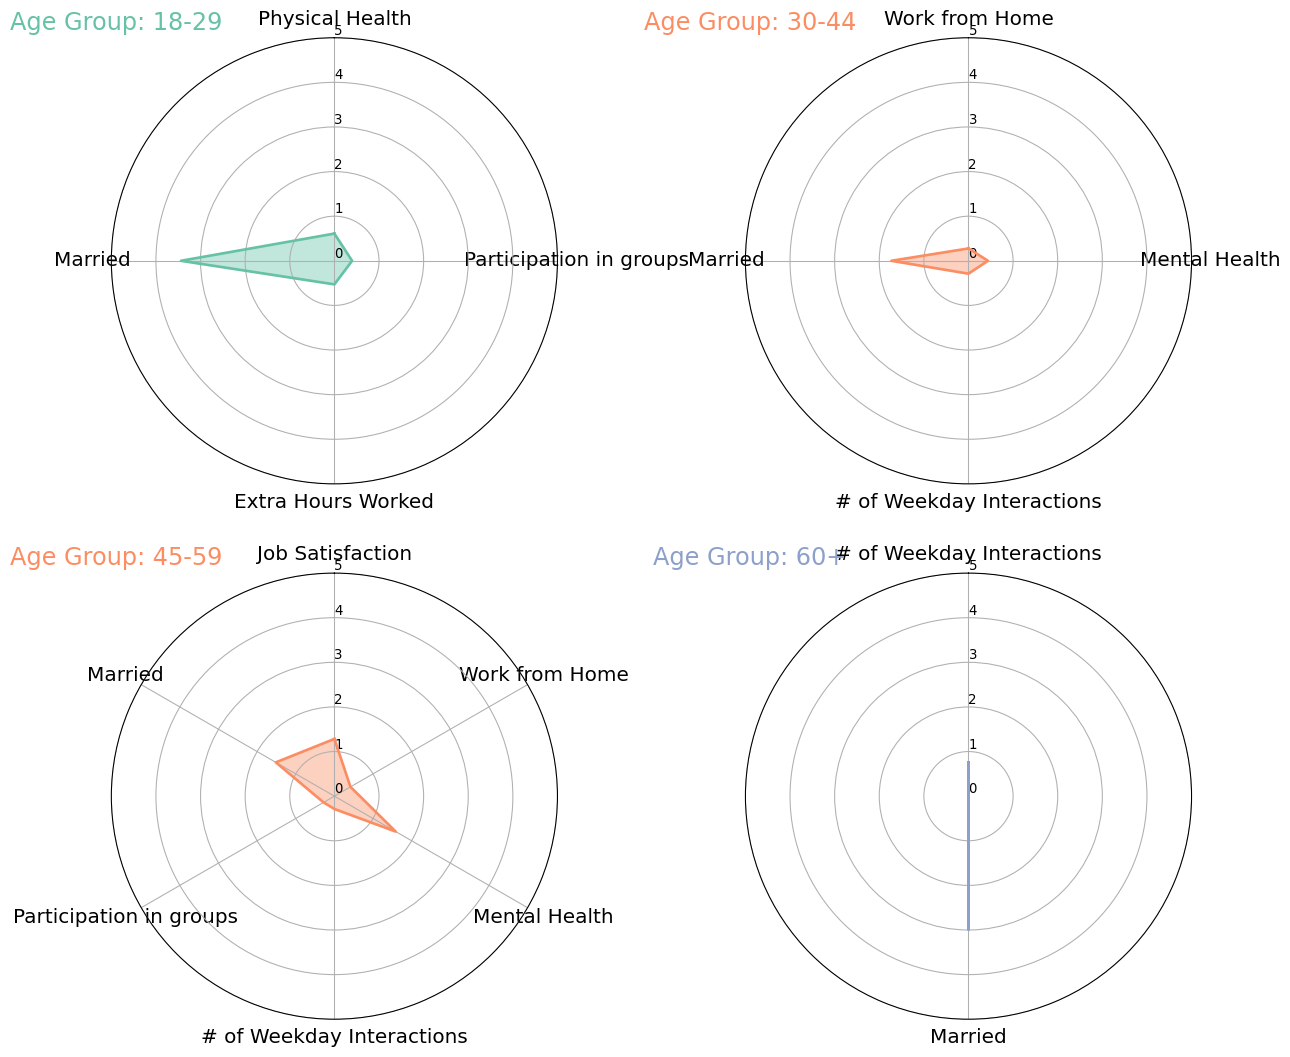

In [55]:
# plotting some radar plots?
# ne
# much courtesy of https://www.python-graph-gallery.com/392-use-faceting-for-radar-chart
# Libraries
#import matplotlib.pyplot as plt
#import pandas as pd
from math import pi


# categories are the var names
# only doing one group. Group A
# values is every value under A plus a repeat of the first (so it closes)
 
# ------- PART 1: Define a function that do a plot for one line of the dataset!
 
def make_spider( row, title, color, df):
    # number of variable
    categories=list(df.index)
    N = len(categories)
    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    
    # Initialise the spider plot
    ax = plt.subplot(2,2,row, polar=True, )
    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='black', size=15)
    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([0,1,2,3,4,5], ["0","1","2",'3','4','5'], color="black", size=10)
    plt.ylim(0,5)
    # Ind1
    #values=df.loc[row].drop('group').values.flatten().tolist()
    # values=df.iloc[:,row-1].tolist()
    values = abs(df['coef']).tolist()
    values += values[:1]
    print(f'{values} {angles}')
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)
    # Add a title
    plt.title(title, size=18, color=color, y=1.0,x=0.01)
    
# ------- PART 2: Apply the function to all individuals
# initialize the figure
my_dpi=96
plt.figure(figsize=(1500/my_dpi, 1300/my_dpi), dpi=my_dpi)
 
# Create a color palette:
my_palette = plt.cm.get_cmap("Set2", len(summary_df.index))
 
# # Loop to plot
# for row in range(0, len(df.index)):
#     make_spider( row=row, title='group '+df['group'][row], color=my_palette(row))
    
for row in summary_df['Age Group'].unique():
    title = ''
    if row == 1:
        title = '18-29'
        #make_spider( row=row, title=f'Age Group: {title}', color=my_palette(row), df = summary_df.loc[summary_df['Age Group'] == row])
        #break
    if row == 2:
        title = '30-44'
        #make_spider( row=row, title=f'Age Group: {title}', color=my_palette(row), df = summary_df.loc[summary_df['Age Group'] == row])
        #break
    if row == 3:
        title = '45-59'
        #make_spider( row=row, title=f'Age Group: {title}', color=my_palette(row), df = summary_df.loc[summary_df['Age Group'] == row])
        #break
    if row == 4:
        title = '60+'
        #make_spider( row=row, title=f'Age Group: {title}', color=my_palette(row), df = summary_df.loc[summary_df['Age Group'] == row])
        #break
    make_spider( row=row, title=f'Age Group: {title}', color=my_palette(row), df = summary_df.loc[summary_df['Age Group'] == row])
    


In [18]:
plot_data = pd.DataFrame(summary_plot)
plot_data['Variable']= plot_data.index

In [19]:
clean_plot_data = pd.DataFrame(pd.crosstab(plot_data['Age Group'],plot_data['Variable'],values=plot_data['coef'],aggfunc=sum))
clean_plot_data

Variable,CONWKDAY,HLTHMNTL,HLTHPHYS,MOREWEEKS,Marital_1,PARTLSC,SATJOB,WRKHOME
Age Group,,,,,,,,
1.0,NaN,NaN,0.6101,-0.5286,-3.4381,-0.3966,NaN,NaN
2.0,-0.2888,0.4365,NaN,NaN,-1.7287,NaN,NaN,-0.2769
3.0,-0.2873,1.5873,NaN,NaN,-1.5153,0.2805,-1.2831,-0.4161
4.0,-0.7550,NaN,NaN,NaN,-2.9782,NaN,NaN,NaN


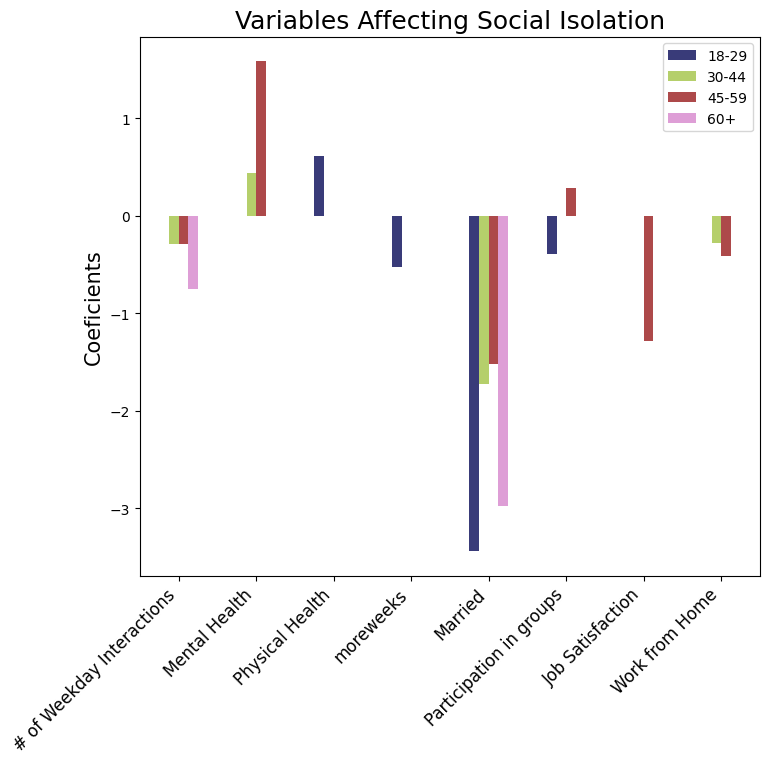

In [20]:
#plt.figure(figsize=(10,10))
ax = clean_plot_data.transpose().plot.bar(figsize=(8,7),rot=0,cmap='tab20b')

plt.title('Variables Affecting Social Isolation', fontsize=18)
plt.ylabel('Coeficients',fontsize=15)
plt.xlabel('',fontsize=15)
ax.tick_params(axis='y',labelsize=10)
ax.tick_params(axis='x', labelsize=12,rotation=45)
ax.set_xticklabels(['# of Weekday Interactions', 'Mental Health', 'Physical Health','moreweeks','Married','Participation in groups','Job Satisfaction','Work from Home'])
plt.setp(ax.xaxis.get_majorticklabels(), ha="right" )
ax.legend(labels=['18-29', '30-44','45-59','60+'])

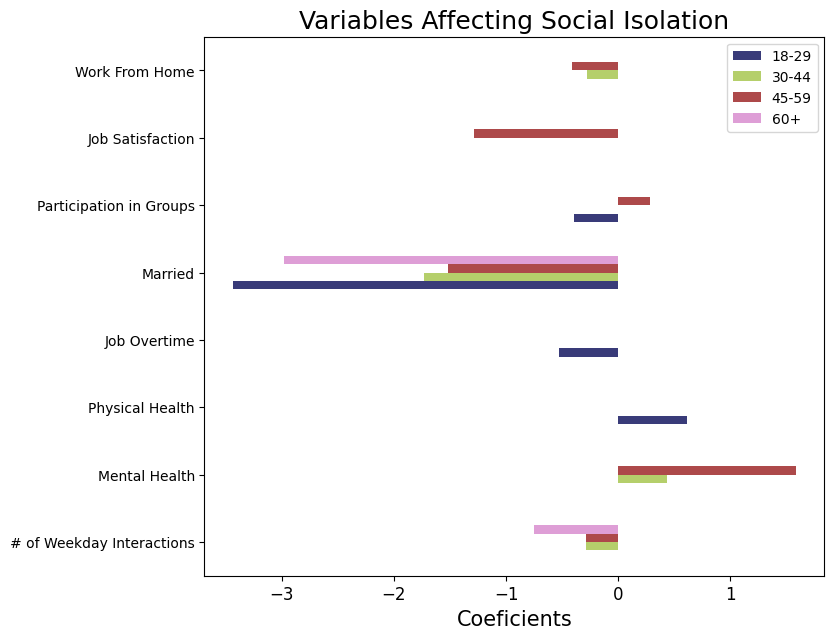

In [21]:
#plt.figure(figsize=(10,10))
ax = clean_plot_data.transpose().plot.barh(figsize=(8,7),rot=0,cmap='tab20b')

plt.title('Variables Affecting Social Isolation', fontsize=18)
plt.xlabel('Coeficients',fontsize=15)
plt.ylabel('',fontsize=15)
ax.tick_params(axis='x',labelsize=12)
ax.tick_params(axis='y', labelsize=10)
ax.set_yticklabels(['# of Weekday Interactions', 'Mental Health', 'Physical Health','Job Overtime','Married','Participation in Groups','Job Satisfaction','Work From Home'])
plt.setp(ax.yaxis.get_majorticklabels(), ha="right" )
ax.legend(labels=['18-29', '30-44','45-59','60+'])